## Film Analysis

The dataset **clean_films_id.csv** contains **9785 rows** and **21 columns** with films released between **1906 and 2024**.

### Questions to Explore:
1. **Sentiment Scores**:  
   - Compare sentiment scores across genres.  
   - Investigate differences in sentiment between movies **with** and **without trigger warnings**.

2. **Sentiment and Reviews**:  
   - Analyze if there is a noticeable difference in sentiment of movie reviews based on **genre** and **trigger warnings**.

3. **Correlations**:  
   - Explore correlations between **sentiment scores**, **movie ratings**, and **box office earnings**.

4. **Impact of Trigger Warnings on Ratings**:  
   - Analyze how the presence of trigger warnings influences movie ratings across platforms (e.g., **IMDb**, **Rotten Tomatoes**).  
   - Use trigger warnings as a categorical variable to compare movie ratings for films **with** and **without trigger warnings**.

5. **Statistical Testing**:  
   - Conduct statistical tests like **t-tests** or **ANOVA** to determine if there’s a significant difference in ratings based on trigger warnings.

6. **Visualizations**:  
   - Create visualizations to illustrate relationships, including:  
     - **Box plots**  
     - **Histograms**  
     - **Scatter plots**

7. **Additional Analysis**:  
   - Perform correlation analysis, hypothesis testing, and trend detection.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [70]:
import sys
sys.path.append('../utils')
sys.path.append('../scripts')
import data_cleaning
import data_inspection
import content_tagging

In [71]:
films = pd.read_csv('../data/clean/clean_films_id.csv')

In [72]:
films = content_tagging.assign_content_tags(films)
films.head()

,title,original_title,genres,director,release_year,runtime,budget,revenue,profit,popularity,...,tmdb_votes,imdb_rating,imdb_votes,language,tmdb_id,imdb_id,doesthedog_id,events,has_warnings,content_tags
0,Traffic in Souls,Traffic in Souls,"crime, drama",George Loane Tucker,1913,88,5700,1800000,1794300,2.3,...,19,5.9,751,English,96128,tt0003471,268281.0,NaN,False,
1,The Birth of a Nation,The Birth of a Nation,"drama, history, war",D.W. Griffith,1915,193,100000,11000000,10900000,13.8,...,520,6.1,26938,English,618,tt0004972,68194.0,"sexual assault, blood or gore, falling deaths,...",True,"Sexual Violence and Abuse, Horror and Supernat..."
2,The Cheat,The Cheat,drama,Cecil B. DeMille,1915,59,17311,137365,120054,6.6,...,64,6.5,2892,English,70368,tt0005078,47532.0,NaN,False,
3,Intolerance: Love's Struggle Throughout the Ages,Intolerance: Love's Struggle Throughout the Ages,"drama, history",D.W. Griffith,1916,197,385907,1750000,1364093,7.4,...,329,7.7,17121,English,3059,tt0006864,46705.0,"kids dying, parents dying, sexual assault, blo...",True,"Sexual Violence and Abuse, Horror and Supernat..."
4,"20,000 Leagues Under the Sea","20,000 Leagues Under the Sea","adventure, drama, action, science fiction",Stuart Paton,1916,99,200000,8000000,7800000,7.9,...,52,6.1,2066,English,30266,tt0006333,226637.0,"shaving or cutting, blood or gore, animals (be...",True,"Horror and Supernatural, Physical Violence, An..."


In [73]:
# data_inspection.show_basic_info(films)

### Weighed Average

1. Count occurrences for each category.
2. Calculate the mean for each category, but weight each category by the number of occurrences.
3. Normalize the means to ensure comparability across categories.

In [74]:
sample_df = films.copy()

In [75]:
# def remove_outliers(df, columns):
#     """
#     Removes outliers from the specified columns using the IQR method.
    
#     Args:
#         df (pd.DataFrame): The DataFrame from which outliers will be removed.
#         columns (list): The list of columns from which outliers will be removed.

#     Returns:
#         pd.DataFrame: DataFrame with outliers removed for the specified columns.
#     """
#     for col in columns:
#         # Calculate the IQR for the column
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
        
#         # Define the upper and lower bounds for the outliers
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         # Remove rows where the column values are outside the bounds
#         df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
#     return df

# columns_to_check = ['imdb_rating', 'tmdb_rating', 'popularity']
# sample_df = remove_outliers(sample_df, columns_to_check)


In [76]:
sample_genres_df = sample_df.assign(genre=sample_df['genres'].str.split(', ')).explode('genre').dropna(subset=['genre'])

sample_events_df = sample_df.dropna(subset=['events']).assign(event=sample_df['events'].str.split(', ')).explode('event').dropna(subset=['event'])

# Exploding the 'content_tag' column, then dropping NaN and empty string values
sample_content_tags_df = (
    sample_df.dropna(subset=['content_tags'])
    .assign(content_tag=sample_df['content_tags'].str.split(', '))
    .explode('content_tag')
    .dropna(subset=['content_tag'])  # Drop NaN values
    .loc[sample_df['content_tags'].str.strip() != '', :]  # Drop empty strings
)


In [77]:
def weighted_mean_with_votes_and_popularity(df, group_col, rating_cols, votes_cols, popularity_col):
    """
    Calculate weighted averages for multiple ratings using corresponding votes and popularity.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        group_col (str): Column to group by (e.g., 'genre').
        rating_cols (list): List of rating columns (e.g., ['tmdb_rating', 'imdb_rating']).
        votes_cols (list): List of vote columns corresponding to rating columns.
        popularity_col (str): Column for popularity weighting.

    Returns:
        pd.DataFrame: Weighted averages by group, including average popularity.
    """
    results = []
    for group, group_df in df.groupby(group_col):
        weighted_sums = {}
        total_weights = 0
        avg_popularity = group_df[popularity_col].mean()  # Calculate average popularity for the group
        
        for rating_col, votes_col in zip(rating_cols, votes_cols):
            valid_data = group_df.dropna(subset=[rating_col, votes_col])
            weights = valid_data[votes_col] * valid_data[popularity_col]  # Weight by votes and popularity
            weighted_sum = (valid_data[rating_col] * weights).sum()
            total_weight = weights.sum()
            
            weighted_sums[rating_col] = round(weighted_sum / total_weight, 1) if total_weight > 0 else None
            total_weights += total_weight
        
        # Append results with rounding to 1 decimal
        results.append({
            group_col: group,
            **{key: round(value, 1) if value is not None else None for key, value in weighted_sums.items()},
            'average_popularity': round(avg_popularity, 1),
            # 'total_weight': round(total_weights, 1)
        })
    
    return pd.DataFrame(results)


In [78]:
# calculate weighted averages
sample_genre_sentiment_weighted = weighted_mean_with_votes_and_popularity(
    sample_genres_df,
    group_col='genre',
    rating_cols=['tmdb_rating', 'imdb_rating'],
    votes_cols=['tmdb_votes', 'imdb_votes'],
    popularity_col='popularity'
)

print('Weighted Average Ratings by Genre with Popularity and Votes:\n')
print(sample_genre_sentiment_weighted)

Weighted Average Ratings by Genre with Popularity and Votes:

              genre  tmdb_rating  imdb_rating  average_popularity
0            action          7.2          7.3                38.7
1         adventure          7.3          7.4                47.9
2         animation          7.4          7.6                58.2
3            comedy          7.1          7.2                23.7
4             crime          7.4          7.8                23.2
5       documentary          7.2          7.0                12.2
6             drama          7.6          7.8                20.0
7            family          7.3          7.3                43.2
8           fantasy          7.2          7.4                39.0
9           history          7.5          7.7                23.8
10           horror          6.8          6.8                30.2
11            music          7.5          7.2                26.7
12          mystery          7.1          7.3                23.4
13          ro

In [79]:
sample_event_sentiment_weighted = weighted_mean_with_votes_and_popularity(
    sample_events_df,
    group_col='event',
    rating_cols=['tmdb_rating', 'imdb_rating'],
    votes_cols=['tmdb_votes', 'imdb_votes'],
    popularity_col='popularity'
)

print('\nWeighted Average Ratings by Trigger Warnings (Events) with Popularity:')
print(sample_event_sentiment_weighted)


Weighted Average Ratings by Trigger Warnings (Events) with Popularity:
                              event  tmdb_rating  imdb_rating  \
0                              9/11          8.0          8.4   
1                       ABA therapy          7.2          7.4   
2            Achilles Tendon injury          7.5          8.0   
3                              BDSM          7.6          7.9   
4          D.I.D. misrepresentation          8.0          8.4   
..                              ...          ...          ...   
192     violent mentally ill person          7.5          7.8   
193                        vomiting          7.3          7.5   
194                wet/soiled pants          7.1          7.3   
195  women brutalized for spectacle          7.4          7.6   
196                   women slapped          7.5          7.8   

     average_popularity  
0                  47.8  
1                  27.4  
2                  47.0  
3                  58.7  
4                

In [80]:
sample_content_sentiment_weighted = weighted_mean_with_votes_and_popularity(
    sample_content_tags_df,
    group_col='content_tag',
    rating_cols=['tmdb_rating', 'imdb_rating'],
    votes_cols=['tmdb_votes', 'imdb_votes'],
    popularity_col='popularity'
)

print('\nWeighted Average Ratings by Content Tags with Popularity:')
print(sample_content_sentiment_weighted)


Weighted Average Ratings by Content Tags with Popularity:
                             content_tag  tmdb_rating  imdb_rating  \
0          Addiction and Substance Abuse          7.3          7.6   
1                           Animal Abuse          7.3          7.5   
2             Body Shaming and Fatphobia          7.4          7.6   
3             Catastrophes and Accidents          7.3          7.6   
4                            Child Abuse          7.4          7.6   
5                        Death and Grief          7.4          7.6   
6                       Fear and Anxiety          7.3          7.5   
7                   Gore and Body Horror          7.3          7.5   
8                Horror and Supernatural          7.3          7.6   
9                          LGBTQ+ Phobia          7.3          7.6   
10                    Medical and Health          7.3          7.5   
11             Mental Health and Ableism          7.3          7.6   
12                     Physical

Visuals

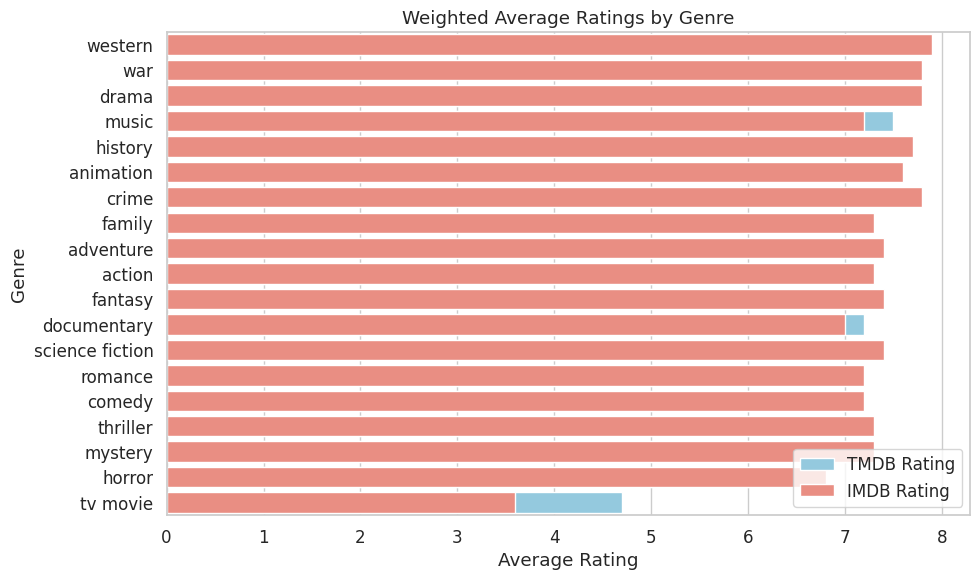

In [81]:
# Visualization setup
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Plot weighted average ratings by genre
plt.figure(figsize=(10, 6))
sns.barplot(
    x='tmdb_rating',
    y='genre',
    data=sample_genre_sentiment_weighted.sort_values(by='tmdb_rating', ascending=False),
    color='skyblue',
    label='TMDB Rating',
)
sns.barplot(
    x='imdb_rating',
    y='genre',
    data=sample_genre_sentiment_weighted.sort_values(by='imdb_rating', ascending=False),
    color='salmon',
    label='IMDB Rating',
)

plt.title('Weighted Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.legend()
plt.tight_layout()
# plt.show()

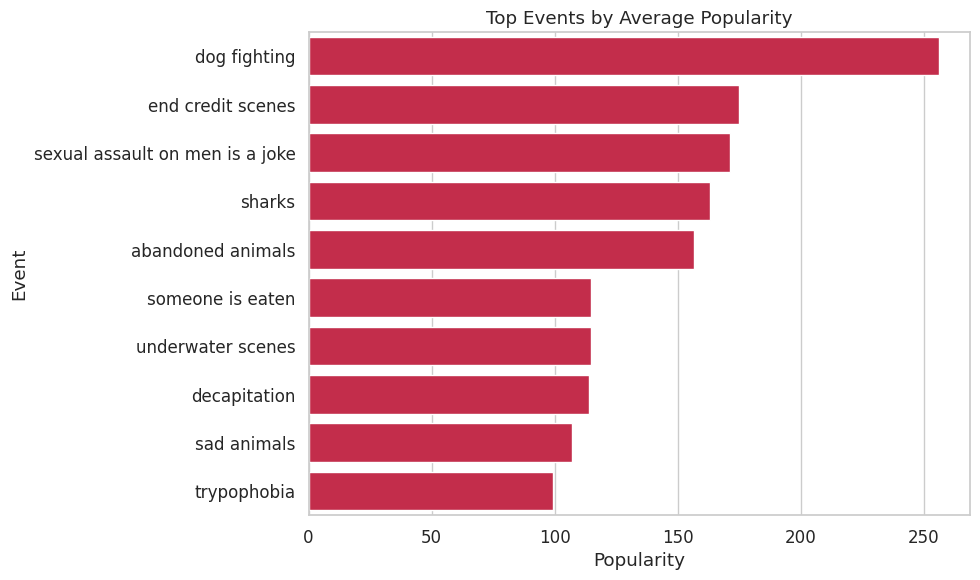

In [82]:
# Top Events by Average Popularity
plt.figure(figsize=(10, 6))
sns.barplot(
    x='average_popularity',
    y='event',
    data=sample_event_sentiment_weighted.sort_values(by='average_popularity', ascending=False).head(10),
    color='crimson',
)

plt.title('Top Events by Average Popularity')
plt.xlabel('Popularity')
plt.ylabel('Event')
plt.tight_layout()
# plt.show()

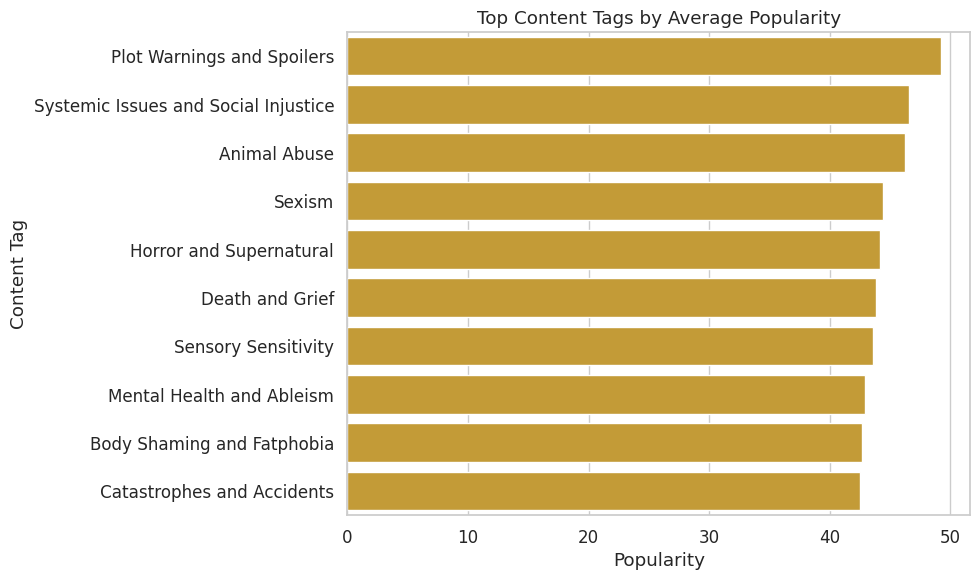

In [83]:
# Top Content Tags by Average Popularity
plt.figure(figsize=(10, 6))
sns.barplot(
    x='average_popularity',
    y='content_tag',
    data=sample_content_sentiment_weighted.sort_values(by='average_popularity', ascending=False).head(10),
    color='goldenrod',
)

plt.title('Top Content Tags by Average Popularity')
plt.xlabel('Popularity')
plt.ylabel('Content Tag')
plt.tight_layout()
# plt.show()

**Impact of Trigger Warnings on Ratings**:  
   - Analyze how the presence of trigger warnings influences movie ratings across platforms (e.g., **IMDb**, **Rotten Tomatoes**).  
   - Use trigger warnings as a categorical variable to compare movie ratings for films **with** and **without trigger warnings**.
   - Welch's t-test is applied, which adjusts for unequal variances and different sample sizes. `equal_var=False`
   - The statistical comparison is reliable even if the number of rows in the two groups (with/without warnings) is different.

In [84]:
# Ensure 'has_warnings' is a boolean
films['has_warnings'] = films['has_warnings'].astype(bool)

# Split the data into two groups: with and without trigger warnings
films_with_warnings = films[films['has_warnings'] == True]
films_without_warnings = films[films['has_warnings'] == False]

# Descriptive Statistics for IMDb Ratings
time_with_mean = films_with_warnings['imdb_rating'].mean()
time_without_mean = films_without_warnings['imdb_rating'].mean()
print(f'Mean IMDb Rating (With Warnings): {time_with_mean:.2f}')
print(f'Mean IMDb Rating (Without Warnings): {time_without_mean:.2f}')

# Independent T-test for IMDb Ratings
t_stat_imdb, p_value_imdb = ttest_ind(
    films_with_warnings['imdb_rating'].dropna(),
    films_without_warnings['imdb_rating'].dropna(),
    equal_var=False  # Welch's t-test if variance is unequal
)
print(f'IMDb Ratings T-test: t-statistic = {t_stat_imdb:.2f}, p-value = {p_value_imdb:.4f}')

# Descriptive Statistics for TMDB Ratings
tmdb_with_mean = films_with_warnings['tmdb_rating'].mean()
tmdb_without_mean = films_without_warnings['tmdb_rating'].mean()
print(f'Mean TMDB Rating (With Warnings): {tmdb_with_mean:.2f}')
print(f'Mean TMDB Rating (Without Warnings): {tmdb_without_mean:.2f}')

# Independent T-test for TMDB Ratings
t_stat_tmdb, p_value_tmdb = ttest_ind(
    films_with_warnings['tmdb_rating'].dropna(),
    films_without_warnings['tmdb_rating'].dropna(),
    equal_var=False
)
print(f'TMDB Ratings T-test: t-statistic = {t_stat_tmdb:.2f}, p-value = {p_value_tmdb:.4f}')

# descriptive stats for popularity
popularity_with_mean = films_with_warnings['popularity'].mean()
popularity_without_mean = films_without_warnings['popularity'].mean()
print(f'Mean popularity (With Warnings): {popularity_with_mean:.2f}')
print(f'Mean popularity (Without Warnings): {popularity_without_mean:.2f}')

# independet t-test for popularity
t_stat_popularity, p_value_popularity = ttest_ind(
    films_with_warnings['popularity'].dropna(),
    films_without_warnings['popularity'].dropna(),
    equal_var=False
)
print(f'Popularity T-test: t-statistic = {t_stat_tmdb:.2f}, p-value = {p_value_tmdb:.4f}')

# Conclusion
if p_value_imdb < 0.05:
    print('There is a significant difference in IMDb ratings between movies with and without trigger warnings.')
else:
    print('No significant difference in IMDb ratings between movies with and without trigger warnings.')

if p_value_tmdb < 0.05:
    print('There is a significant difference in TMDB ratings between movies with and without trigger warnings.')
else:
    print('No significant difference in TMDB ratings between movies with and without trigger warnings.')
if p_value_popularity < 0.05:
    print('There is a significant difference in popularity ratings between movies with and without trigger warnings.')
else:
    print('No significant difference in popularity ratings between movies with and without trigger warnings.')

Mean IMDb Rating (With Warnings): 6.55
Mean IMDb Rating (Without Warnings): 6.10
IMDb Ratings T-test: t-statistic = 20.89, p-value = 0.0000
Mean TMDB Rating (With Warnings): 6.59
Mean TMDB Rating (Without Warnings): 6.12
TMDB Ratings T-test: t-statistic = 26.98, p-value = 0.0000
Mean popularity (With Warnings): 36.67
Mean popularity (Without Warnings): 13.58
Popularity T-test: t-statistic = 26.98, p-value = 0.0000
There is a significant difference in IMDb ratings between movies with and without trigger warnings.
There is a significant difference in TMDB ratings between movies with and without trigger warnings.
There is a significant difference in popularity ratings between movies with and without trigger warnings.


#### Effect Size
Add an effect size metric (like Cohen's d) to measure the magnitude of the difference between means.

In [85]:

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 + (ny - 1) * np.std(y, ddof=1)**2) / dof)

d_imdb = cohen_d(
    films_with_warnings['imdb_rating'].dropna(),
    films_without_warnings['imdb_rating'].dropna()
)
print(f"Cohen's d for IMDb Ratings: {d_imdb:.2f}")

Cohen's d for IMDb Ratings: 0.44


In [86]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 + (ny - 1) * np.std(y, ddof=1)**2) / dof)

t_tmdb = cohen_d(
    films_with_warnings['tmdb_rating'].dropna(),
    films_without_warnings['tmdb_rating'].dropna()
)
print(f"Cohen's d for TMDb Ratings: {t_tmdb:.2f}")

Cohen's d for TMDb Ratings: 0.56


In [87]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 + (ny - 1) * np.std(y, ddof=1)**2) / dof)

t_popularity = cohen_d(
    films_with_warnings['popularity'].dropna(),
    films_without_warnings['popularity'].dropna()
)
print(f"Cohen's d for popularity: {t_popularity:.2f}")

Cohen's d for popularity: 0.16
